In [1]:
import json
import requests
import flickrapi
import pandas as pd
from tqdm import tqdm
from vincenty import vincenty
import matplotlib.pyplot as plt
import time
import geopandas
import numpy as np
import io
import contextily as ctx

ImportError: DLL load failed while importing _network: The specified module could not be found.

In [26]:
api_key = u'b766ae533b2843f748b174f53885eee4'
api_secret = u'ac3884caa9690723'

In [27]:
flickr = flickrapi.FlickrAPI(api_key, api_secret, format='json')

In [28]:
min_lat = 59.800
max_lat = 69.910

# for Veronica
min_lon = 20.410
max_lon = 25.410


# for Ashish
#min_lon = 25.410
#max_lon = 30.410

n_lat = 6
n_lon = 2

start_lat = min_lat
start_lon = min_lon

lats = np.arange(min_lat, max_lat, (max_lat-min_lat)/n_lat)
lons = np.arange(min_lon, max_lon, (max_lon-min_lon)/n_lon)

bboxes = []

for i_lat, lat in enumerate(lats):
    if  (i_lat + 1 == n_lat):
        end_lat = max_lat
    else:
        end_lat = lats[i_lat+1]
            
    for i_lon, lon in enumerate(lons):
        if (i_lon + 1 == n_lon):
            end_lon = max_lon
        else:
            end_lon = lons[i_lon+1]
        
        bbox = (lon, lat, end_lon, end_lat)
        bboxes.append(bbox)

print(bboxes)
print(len(bboxes))

[(20.41, 59.8, 22.91, 61.485), (22.91, 59.8, 25.41, 61.485), (20.41, 61.485, 22.91, 63.17), (22.91, 61.485, 25.41, 63.17), (20.41, 63.17, 22.91, 64.855), (22.91, 63.17, 25.41, 64.855), (20.41, 64.855, 22.91, 66.54), (22.91, 64.855, 25.41, 66.54), (20.41, 66.54, 22.91, 68.22500000000001), (22.91, 66.54, 25.41, 68.22500000000001), (20.41, 68.22500000000001, 22.91, 69.91), (22.91, 68.22500000000001, 25.41, 69.91)]
12


## Test flickr API

In [29]:
photos = flickr.photos.search(per_page='250', bbox='20.410, 59.800, 30.920, 69.910', has_geo=1)
parsed = json.loads(photos.decode('utf-8'))

id = parsed['photos']['photo'][0]['id']
geo = flickr.do_flickr_call('flickr.photos.geo.getLocation', photo_id=id)
geo_parsed = json.loads(geo.decode('utf-8'))
print(geo_parsed)


{'photos': {'page': 1, 'pages': 938, 'perpage': 250, 'total': '234258', 'photo': [{'id': '50991982323', 'owner': '63796798@N00', 'secret': '516cebe7e0', 'server': '65535', 'farm': 66, 'title': 'Tukkutori', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id': '50992666801', 'owner': '63796798@N00', 'secret': '033c679dac', 'server': '65535', 'farm': 66, 'title': 'There is no way to peace, peace is the way', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id': '50992084416', 'owner': '16391511@N00', 'secret': 'f513ac14b2', 'server': '65535', 'farm': 66, 'title': 'Ice-Covered Taivallahti', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id': '50990491786', 'owner': '70192309@N03', 'secret': 'e3d7c6bf4a', 'server': '65535', 'farm': 66, 'title': 'Lightroom-852', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id': '50990264196', 'owner': '91977610@N00', 'secret': 'a39ae4fc18', 'server': '65535', 'farm': 66, 'title': "St. Isaac's Cathedral", 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id'

{'photo': {'id': '50991982323', 'location': {'latitude': '60.191519', 'longitude': '24.973572', 'accuracy': '16', 'context': '0', 'locality': {'_content': 'Helsinki'}, 'county': {'_content': 'Helsinki'}, 'region': {'_content': 'Newland'}, 'country': {'_content': 'Finland'}, 'neighbourhood': {'_content': 'Hermanni'}}}, 'stat': 'ok'}
Helsinki


## Collect picture ids for the set of bboxes

In [48]:
photos_set = []
for b in bboxes:
    # Let's count the pages!
    bbox = '{}, {}, {}, {}'.format(b[0], b[1], b[2], b[3])
    res = flickr.photos.search(per_page='250', bbox=bbox, has_geo=1)
    parsed = json.loads(res.decode('utf-8'))
    pages = int(parsed['photos']['pages'])
    print(bbox)
    for page in tqdm(range(1, pages + 1)):
        res = flickr.photos.search(page=page, per_page='250', bbox=bbox, has_geo=1)
        parsed = json.loads(res.decode('utf-8'))
        for p in parsed['photos']['photo']:
            photos_set.append(p)


  0%|                                                                                                                                                                                                                                              | 0/154 [00:00<?, ?it/s]

20.41, 59.8, 22.91, 61.485


  0%|                                                                                                                                                                                                                                             | 0/1045 [00:00<?, ?it/s]

22.91, 59.8, 25.41, 61.485


  0%|                                                                                                                                                                                                                                               | 0/72 [00:00<?, ?it/s]

20.41, 61.485, 22.91, 63.17


  0%|                                                                                                                                                                                                                                              | 0/191 [00:00<?, ?it/s]

22.91, 61.485, 25.41, 63.17


  0%|                                                                                                                                                                                                                                               | 0/40 [00:00<?, ?it/s]

20.41, 63.17, 22.91, 64.855


  0%|                                                                                                                                                                                                                                               | 0/21 [00:00<?, ?it/s]

22.91, 63.17, 25.41, 64.855


  0%|                                                                                                                                                                                                                                               | 0/34 [00:00<?, ?it/s]

20.41, 64.855, 22.91, 66.54


  0%|                                                                                                                                                                                                                                               | 0/88 [00:00<?, ?it/s]

22.91, 64.855, 25.41, 66.54


  0%|                                                                                                                                                                                                                                               | 0/18 [00:00<?, ?it/s]

20.41, 66.54, 22.91, 68.22500000000001


  0%|                                                                                                                                                                                                                                               | 0/52 [00:00<?, ?it/s]

22.91, 66.54, 25.41, 68.22500000000001


  0%|                                                                                                                                                                                                                                               | 0/17 [00:00<?, ?it/s]

20.41, 68.22500000000001, 22.91, 69.91


  0%|                                                                                                                                                                                                                                               | 0/13 [00:00<?, ?it/s]

22.91, 68.22500000000001, 25.41, 69.91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.88it/s]


In [49]:
len(photos_set)

414095

In [23]:
photos_set[10]

{'id': '50988487597',
 'owner': '41505253@N00',
 'secret': '980eaf04e3',
 'server': '65535',
 'farm': 66,
 'title': 'Late winter 2020-21',
 'ispublic': 1,
 'isfriend': 0,
 'isfamily': 0}

## Check for duplicates and remove if any

In [50]:
ids_df = pd.DataFrame(photos_set)
duplicateRowsDF = ids_df[ids_df.duplicated()]
print(len(ids_df))
len(duplicateRowsDF)

414095


373584

In [52]:
ids_df = ids_df.drop_duplicates()
duplicateRowsDF = ids_df[ids_df.duplicated()]
print(len(ids_df))
len(duplicateRowsDF)
ids_df.to_csv('dataset/veronika_photo_ids.csv', index=False)

40511


In [83]:
photos_set = ids_df.to_dict(orient='records')

[{'id': '50992175337', 'owner': '46915646@N06', 'secret': '71f03f815e', 'server': '65535', 'farm': 66, 'title': 'Spring', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id': '50988380961', 'owner': '41505253@N00', 'secret': '5e36bd1410', 'server': '65535', 'farm': 66, 'title': 'Late winter 2020-21', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id': '50988488177', 'owner': '41505253@N00', 'secret': '009ab112e5', 'server': '65535', 'farm': 66, 'title': 'Late winter 2020-21', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}, {'id': '50988380816', 'owner': '41505253@N00', 'secret': '960ab8b736', 'server': '65535', 'farm': 66, 'title': 'Late winter 2020-21', 'ispublic': 1, 'isfriend': 0, 'isfamily': 0}]
40511


In [94]:
def add_df_to_csv(df):
    with io.open('dataset/veronika_all.csv', 'a', encoding="utf-8") as f:
        df.to_csv(f, header=False)


In [102]:
# photo_id, lat, lon, name, locality, neighbourhood
photo_ids = []
lats = []
longs = []
names = []
localities = []
neighbourhoods = []
regions = []
i = 0


for p in tqdm(photos_set[3195+3568+7900+1160+8700+4800:]):
    photo_id = p['id']
    geo = flickr.do_flickr_call('flickr.photos.geo.getLocation', photo_id=photo_id)
    parsed = json.loads(geo.decode('utf-8'))
    ## construct arrays of data
    if 'photo' not in parsed:
        continue
    photo_ids.append(photo_id)
    names.append(p['title'])      
    lats.append(parsed['photo']['location']['latitude'])
    longs.append(parsed['photo']['location']['longitude'])
    neighbourhoods.append(parsed['photo']['location']['neighbourhood']['_content'])
    if 'locality' in parsed['photo']['location']:
        localities.append(parsed['photo']['location']['locality']['_content'])
    else:
        localities.append('Unknown')
    if 'region' in parsed['photo']['location']:
        regions.append(parsed['photo']['location']['region']['_content'])
    else:
        regions.append('Unknown')
    i = i + 1    
    if i % 100 == 0:
        df = pd.DataFrame({'id': photo_ids,
                  'name': names,
                  'lat': lats,
                  'lon': longs,
                  'locality': localities,
                  'region': regions,
                  'neighbourhood': neighbourhoods})
        add_df_to_csv(df)
        photo_ids = []
        lats = []
        longs = []
        names = []
        localities = []
        neighbourhoods = []
        regions = []

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11188/11188 [42:38<00:00,  4.37it/s]


In [10]:
df = pd.read_csv('../dataset/dataset.csv', header=0, names=['id', 'name', 'lat', 'lon', 'locality', 'region', 'neighbourhood'])
df.iloc[1008:1014]

,id,name,lat,lon,locality,region,neighbourhood
1008,48679032053,Milky Way and star flight,60.802904,21.269917,Uusikaupunki,Finland Proper,Lepäinen
1009,48670346741,VW 1300cc 44bhp,60.407569,21.887319,Naantali,Finland Proper,Poikko
1010,48663541293,"Suopohja, kadun pohjatyöt, elokuun loppu 2019",60.461469,22.446700,Lieto,Finland Proper,Suopohja
1011,48653249877,Mushrooms,60.415850,22.819547,Paimio,Finland Proper,Kurki
1012,48647388622,Sunset,60.093611,21.625277,Pargas,Finland Proper,Lom
1013,48632222116,My beloved cat Sera,61.127056,21.532216,Rauma,Satakunta,Lensunkallio


In [11]:
len(df)

76879

In [53]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))

C:\Users\blazhko\Anaconda3\envs\cn\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\Users\blazhko\Anaconda3\envs\cn\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


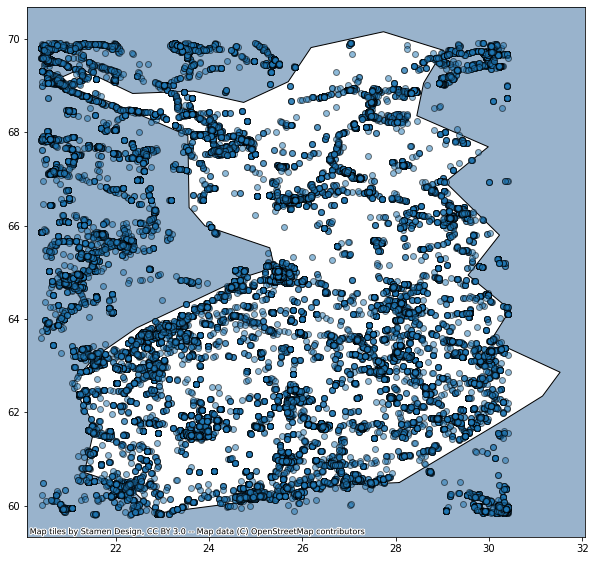

In [55]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'), bbox=(20.410, 59.800, 30.920, 69.910))

ax = world[world.name == 'Finland'].plot(figsize=(10, 10),
    color='white', edgecolor='black')
ctx.add_basemap(ax)
gdf.plot(ax=ax, alpha=0.5, edgecolor='k')

plt.show()